# Tempest and the KS relation 

Generation 1 of the FOGGIE simulations uses Enzo's most simplified star formation prescription, the Cen & Ostriker method. We need to improve this. So with a view toward adopting another method, or implementing a variant, let's look at how the existing method behaves and how it might be adjusted to be more realistic. 

First thing we do is our imports, and then we open the FOGGIE snapshot in the usual way. 

In [1]:
import yt
import numpy as np, os
from foggie.utils.foggie_load import *
import matplotlib.pyplot as plt
from yt.funcs import mylog
from numpy.polynomial import Polynomial
mylog.setLevel(40)

##### First we open a FOGGIE dataset for Tempest

In [2]:
dataset_name = 'kmt_test/nref12c_nref9f/DD2339/DD2339'
trackname = os.getenv('DROPBOX_DIR') + '/FOGGIE/foggie/foggie/halo_tracks/008508/nref11n_selfshield_15/halo_track_200kpc_nref10'
ds, region = foggie_load(dataset_name, trackname) 
ad = ds.all_data() 

Opening snapshot kmt_test/nref12c_nref9f/DD2339/DD2339
get_refine_box: using this location:        col1         col2     col3     col4     col5     col6     col7   col8
----------------- -------- -------- -------- -------- -------- -------- ----
0.035488180836906 0.488989 0.470847 0.508313 0.490989 0.472847 0.510313   10


Parsing Hierarchy : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7894/7894 [00:00<00:00, 22049.16it/s]


This halo_c_v file doesn't exist, calculating halo center...
get_halo_centers:  code_length code_velocity
we have obtained the spherical region
we have extracted the DM density
 we have obtained the preliminary center
got the velocities
Located the main halo at: [0.4899706840515137, 0.47173357009887695, 0.5093197822570802] [unyt_quantity(-3.33216715e-05, 'code_velocity'), unyt_quantity(-0.00230715, 'code_velocity'), unyt_quantity(0.0004348, 'code_velocity')]
filtering young_stars particles...
filtering young_stars3 particles...
filtering young_stars8 particles...
filtering old_stars particles...
filtering stars particles...
filtering dm particles...


###### Now let's do a projection plot of the density for reference.


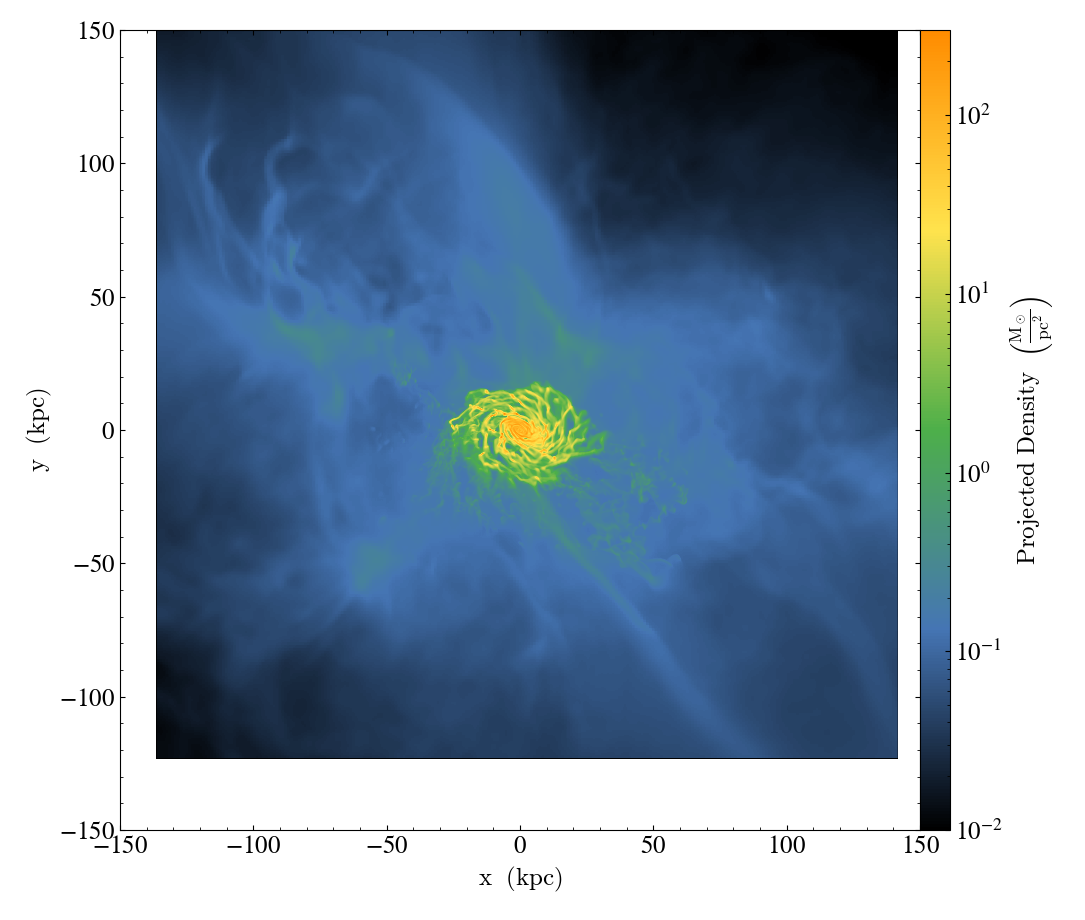

In [15]:
p = yt.ProjectionPlot(ds, 'z', 'density', data_source=region, width=(300, 'kpc'), center=ds.halo_center_code)
p.set_unit('density','Msun/pc**2')
p.set_cmap('density', density_color_map)
p.set_zlim('density',0.01,300)
p.show()

###### Now we can do a projection of the "young stars" (with creation time in the last 3 Myr) for comparison. 


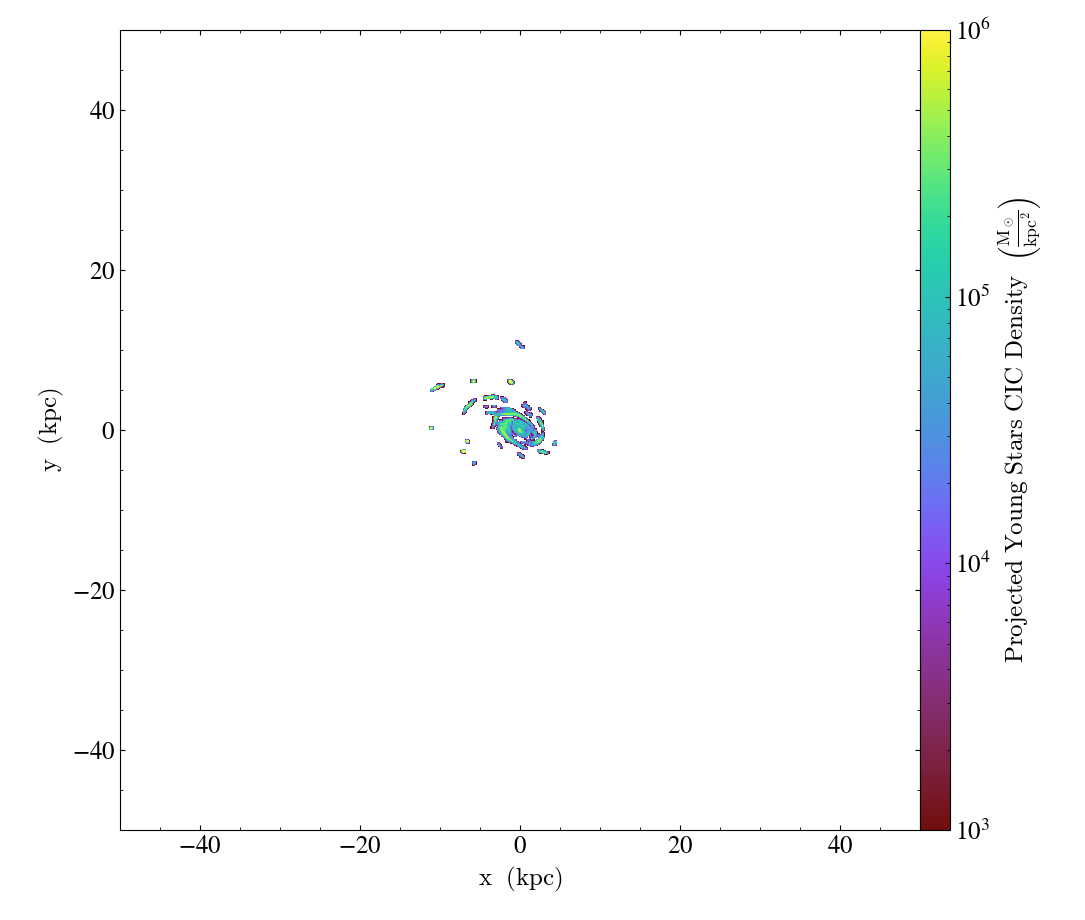

In [12]:
p = yt.ProjectionPlot(ds, 'z', ('deposit', 'young_stars_cic'), width=(100, 'kpc'), data_source=region, center=ds.halo_center_code)
p.set_unit(('deposit','young_stars_cic'),'Msun/kpc**2')
p.set_zlim(('deposit','young_stars_cic'),1000,1000000)
p.show()

#### Now, project the gas density to a surface density for comparison to the SFR. This is the x-axis of the KS plot. 

In [13]:
proj_frb = p.data_source.to_frb((100., "kpc"), 500)

In [6]:
projected_density = proj_frb['density'].in_units('Msun/pc**2')
ks_nh1 = proj_frb['H_p0_number_density'].in_units('pc**-2') * yt.YTArray(1.67e-24/1.989e33, 'Msun') 

#### Now, project the young stars to a surface density for comparison to the gas. This is the y-axis of the KS plot. 

In [7]:
young_stars = proj_frb[('deposit', 'young_stars_cic')].in_units('Msun/kpc**2')
ks_sfr = young_stars / yt.YTArray(3e6, 'yr') + yt.YTArray(1e-6, 'Msun/kpc**2/yr')

#### Next, define the KS relation in two vectors that can be interpolated. These are values data-thiefed from the KMT09 plot. 

In [8]:
log_sigma_gas = [0.5278, 0.6571, 0.8165, 1.0151, 1.2034, 1.4506, 1.6286, 1.9399, 2.2663, 2.7905, 3.5817]
log_sigma_sfr = [-5.1072, -4.4546, -3.5572, -2.7926, -2.3442, -2.0185, -1.8253, -1.5406, -1.0927, -0.3801, 0.6579]

c = Polynomial.fit(log_sigma_gas, log_sigma_sfr, deg=5)

(-6.0, 3.0)

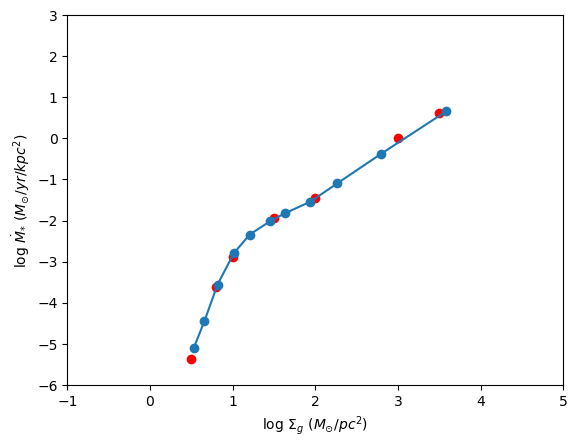

In [9]:
plt.plot(log_sigma_gas, log_sigma_sfr, marker='o')
plt.xlabel('log $\Sigma _{g} \,\, (M_{\odot} / pc^2)$')
plt.ylabel('log $\dot{M} _{*} \,\, (M_{\odot} / yr / kpc^2)$')

plt.scatter(0.5, c(0.5), color='red')
plt.scatter(0.8, c(0.8), color='red')
plt.scatter(1, c(1), color='red')
plt.scatter(1.5, c(1.5), color='red')
plt.scatter(2, c(2), color='red')
plt.scatter(3, c(3), color='red')
plt.scatter(3.5, c(3.5), color='red')
plt.xlim(-1, 5)
plt.ylim(-6,3)

#### We now have all the elements of the KS relation, so make the plot. 

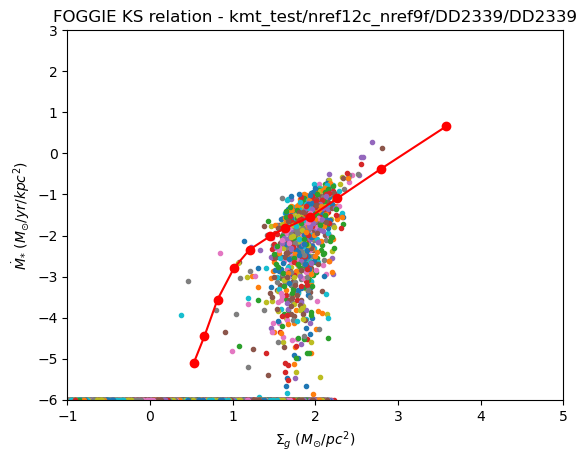

In [10]:
plt.plot(np.log10(ks_nh1), np.log10(ks_sfr), '.')
plt.plot(log_sigma_gas, log_sigma_sfr, marker='o', color='red')
plt.xlabel('$\Sigma _{g} \,\, (M_{\odot} / pc^2)$')
plt.ylabel('$\dot{M} _{*} \,\, (M_{\odot} / yr / kpc^2)$')
plt.xlim(-1,5)
plt.title('FOGGIE KS relation - '+dataset_name)
plt.ylim(-6,3)
plt.show()

This doesn't look right at all - it's practical vertical and does not follow the KS relation. It's both way too high and way too low, owing to some combination of the star formation threshold and effieciency. Rather than just start adjusting this in simulations, let's look at the gas surface densities, that are present and ask where Tempest *should* be forming stars. 

In [ ]:
EndTime = yt.YTArray(ds.parameters['#TimeUnits'] * ds.parameters['StopTime'], 's').in_units('yr')

In [ ]:
particle_mass3 = ad['young_stars3' , 'particle_mass']

In [ ]:
time3 = ad['young_stars3' , 'creation_time'].in_units('yr')

In [ ]:
xx = plt.hist(np.array(EndTime-time3)) 
plt.show() 

In [ ]:
particle_mass3.in_units('Msun')

In [ ]:
xx = plt.hist(np.array(particle_mass3.in_units('Msun')), bins=100)
plt.xlim(0,5000)
plt.show()

In [ ]:
plt.scatter(np.array(particle_mass3.in_units('Msun')), np.array(EndTime-time3), marker='.')
plt.xlim(0,5000)

In [ ]:
particle_mass3.sum().in_units('Msun') / yt.YTArray(1e7, 'yr') 

In [ ]:
(particle_mass3[particle_mass3.in_units('Msun')  > 1000.]).in_units('Msun').sum() / 1e7

In [ ]:
particle_mass3.min() / 1.989e33

In [ ]:
particle_mass3.mean().in_units('Msun')

In [ ]:
(particle_mass3[particle_mass3.in_units('Msun') > 1000.]).size 

In [ ]:
(particle_mass3[particle_mass3.in_units('Msun') < 1000.]).size 

In [ ]:
ad[('young_stars3', 'particle_mass')] 